In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import time
import os
from dataclasses import dataclass
from collections import namedtuple
import pyro
import optax
from pyro.infer import SVI, TraceGraph_ELBO
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.contrib.examples.multi_mnist as multi_mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata
import genjax
from genjax import grasp

key = jax.random.PRNGKey(314159)
console = genjax.pretty()
sns.set_theme(style="white")
font_path = (
    "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Lato/Lato_Bold.ttf"
)
font_manager.fontManager.addfont(font_path)
custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
rcParams["font.family"] = custom_font_name

console = genjax.pretty()
label_fontsize = 70  # Set the desired font size here

smoke_test = "CI" in os.environ
assert pyro.__version__.startswith("1.8.6")

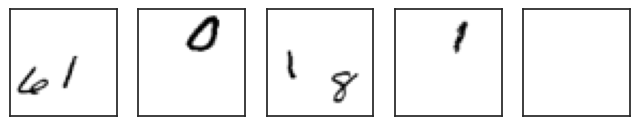

In [2]:
inpath = "./data/air/.data"
X_np, Y = multi_mnist.load(inpath)
X_np = X_np.astype(np.float32)
X_np /= 255.0
mnist = jnp.array(X_np)
true_counts = jnp.array([len(objs) for objs in Y])


def show_images(imgs):
    fig = plt.figure(figsize=(8, 2))
    for i, img in enumerate(imgs):
        ax = plt.subplot(1, len(imgs), i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img, cmap="gray_r")


show_images(mnist[9:14])

## Defining the variational ingredients

### Utilities / learnable pieces

In [3]:
from genjax import Pytree
import equinox as eqx
from genjax.typing import Any
from genjax.typing import Tuple
from genjax.typing import FloatArray
from genjax.typing import Int
from genjax.typing import IntArray
from genjax.typing import PRNGKey
from genjax.typing import typecheck

# Utilities for defining the model and the guide.


@dataclass
class Decoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(50, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 400, key=key2)
        return Decoder(dense_1, dense_2)

    def __call__(self, z_what):
        v = self.dense_1(z_what)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return jax.nn.sigmoid(v)


# Create our decoder.
key, sub_key1, sub_key2 = jax.random.split(key, 3)
decoder = Decoder.new(sub_key1, sub_key2)

# Create our RNN for the guide.
key, sub_key = jax.random.split(key)
rnn = eqx.nn.LSTMCell(2554, 256, key=sub_key)


@dataclass
class Encoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(400, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 100, key=key2)
        return Encoder(dense_1, dense_2)

    def __call__(self, data):
        v = self.dense_1(data)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return v[0:50], jax.nn.softplus(v[50:])


key, sub_key1, sub_key2 = jax.random.split(key, 3)
encoder = Encoder.new(sub_key1, sub_key2)


@dataclass
class Predict(Pytree):
    dense: Any

    def flatten(self):
        return (self.dense,), ()

    @classmethod
    def new(cls, key):
        dense = eqx.nn.Linear(256, 7, key=key)
        return Predict(dense)

    def __call__(self, h):
        a = self.dense(h)
        z_pres_p = jax.nn.sigmoid(a[0:1])
        z_where_loc = a[1:4]
        z_where_scale = jax.nn.softplus(a[4:])
        return z_pres_p, z_where_loc, z_where_scale


key, sub_key = jax.random.split(key)
predict = Predict.new(key)

In [4]:
#######
# STN #
#######

# modified from https://github.com/kevinzakka/spatial-transformer-network/blob/master/stn/transformer.py


def affine_grid_generator(height, width, theta):
    """
    This function returns a sampling grid, which when
    used with the bilinear sampler on the input feature
    map, will create an output feature map that is an
    affine transformation [1] of the input feature map.

    Input
    -----
    - height: desired height of grid/output. Used
      to downsample or upsample.

    - width: desired width of grid/output. Used
      to downsample or upsample.

    - theta: affine transform matrices of shape (num_batch, 2, 3).
      For each image in the batch, we have 6 theta parameters of
      the form (2x3) that define the affine transformation T.

    Returns
    -------
    - normalized grid (-1, 1) of shape (num_batch, 2, H, W).
      The 2nd dimension has 2 components: (x, y) which are the
      sampling points of the original image for each point in the
      target image.

    Note
    ----
    [1]: the affine transformation allows cropping, translation,
         and isotropic scaling.
    """
    num_batch = theta.shape[0]

    # create normalized 2D grid
    x = jnp.linspace(-1.0, 1.0, width)
    y = jnp.linspace(-1.0, 1.0, height)
    x_t, y_t = jnp.meshgrid(x, y)

    # flatten
    x_t_flat = jnp.reshape(x_t, [-1])
    y_t_flat = jnp.reshape(y_t, [-1])

    # reshape to [x_t, y_t , 1] - (homogeneous form)
    ones = jnp.ones_like(x_t_flat)
    sampling_grid = jnp.stack([x_t_flat, y_t_flat, ones])

    # repeat grid num_batch times
    sampling_grid = jnp.expand_dims(sampling_grid, axis=0)
    sampling_grid = jnp.tile(sampling_grid, [num_batch, 1, 1])

    # transform the sampling grid - batch multiply
    batch_grids = jnp.matmul(theta, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)

    # reshape to (num_batch, 2, H, W)
    batch_grids = jnp.reshape(batch_grids, [num_batch, 2, height, width])

    return batch_grids


def bilinear_sampler(img, x, y):
    """
    Performs bilinear sampling of the input images according to the
    normalized coordinates provided by the sampling grid. Note that
    the sampling is done identically for each channel of the input.

    To test if the function works properly, output image should be
    identical to input image when theta is initialized to identity
    transform.

    Input
    -----
    - img: batch of images in (B, H, W, C) layout.
    - grid: x, y which is the output of affine_grid_generator.

    Returns
    -------
    - out: interpolated images according to grids. Same size as grid.
    """
    H = jnp.shape(img)[1]
    W = jnp.shape(img)[2]
    max_y = H - 1
    max_x = W - 1
    zero = jnp.zeros([], dtype=int)

    # rescale x and y to [0, W-1/H-1]
    x = 0.5 * ((x + 1.0) * max_x - 1)
    y = 0.5 * ((y + 1.0) * max_y - 1)

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = jnp.floor(x).astype(int)
    x1 = x0 + 1
    y0 = jnp.floor(y).astype(int)
    y1 = y0 + 1

    # clip to range [0, H-1/W-1] to not violate img boundaries
    x0 = jnp.clip(x0, zero, max_x)
    x1 = jnp.clip(x1, zero, max_x)
    y0 = jnp.clip(y0, zero, max_y)
    y1 = jnp.clip(y1, zero, max_y)

    # get pixel value at corner coords
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    # recast as float for delta calculation
    x0 = x0.astype(float)
    x1 = x1.astype(float)
    y0 = y0.astype(float)
    y1 = y1.astype(float)

    # calculate deltas
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    # add dimension for addition
    wa = jnp.expand_dims(wa, axis=3)
    wb = jnp.expand_dims(wb, axis=3)
    wc = jnp.expand_dims(wc, axis=3)
    wd = jnp.expand_dims(wd, axis=3)

    # compute output
    out = wa * Ia + wb * Ib + wc * Ic + wd * Id
    return out


def get_pixel_value(img, x, y):
    """
    Utility function to get pixel value for coordinate
    vectors x and y from a  4D tensor image.

    Input
    -----
    - img: tensor of shape (B, H, W, C)
    - x: flattened tensor of shape (B*H*W,)
    - y: flattened tensor of shape (B*H*W,)

    Returns
    -------
    - output: tensor of shape (B, H, W, C)
    """
    batch_size, height, width = jnp.shape(x)

    batch_idx = jnp.arange(0, batch_size)
    batch_idx = jnp.reshape(batch_idx, (batch_size, 1, 1))
    b = jnp.tile(batch_idx, (1, height, width))

    indices = jnp.stack([b, y, x], 3)

    return gather_nd(img, indices)


# from: https://github.com/google/jax/discussions/6119
def gather_nd_unbatched(params, indices):
    return params[tuple(jnp.moveaxis(indices, -1, 0))]


def gather_nd(params, indices, batch=False):
    if not batch:
        return gather_nd_unbatched(params, indices)
    else:
        return vmap(gather_nd_unbatched, (0, 0), 0)(params, indices)


def expand_z_where(z_where):
    # Takes 3-dimensional vectors, and massages them into 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = 1
    expansion_indices = jnp.array([1, 0, 2, 0, 1, 3])
    z_where = jnp.expand_dims(z_where, axis=0)
    out = jnp.concatenate((jnp.broadcast_to(jnp.zeros([1, 1]), (n, 1)), z_where), 1)
    return jnp.reshape(out[:, expansion_indices], (n, 2, 3))


def object_to_image(z_where, obj):
    n = 1
    theta = expand_z_where(z_where)
    grid = affine_grid_generator(50, 50, theta)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(obj, (n, 20, 20, 1)), x_s, y_s)
    return jnp.reshape(out, (50, 50))


def z_where_inv(z_where):
    # Take a batch of z_where vectors, and compute their "inverse".
    # That is, for each row compute:
    # [s,x,y] -> [1/s,-x/s,-y/s]
    # These are the parameters required to perform the inverse of the
    # spatial transform performed in the generative model.
    n = 1
    out = jnp.array([1, *(-z_where[1:])])
    out = out / z_where[0]
    return out


def image_to_object(z_where, image):
    n = 1
    theta_inv = expand_z_where(z_where_inv(z_where))
    grid = affine_grid_generator(20, 20, theta_inv)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(image, (n, 50, 50, 1)), x_s, y_s)
    return jnp.reshape(out, (400,))

### Model

In [5]:
#########
# Model #
#########

# Fixed constants.
z_where_prior_loc = jnp.array([3.0, 0.0, 0.0])
z_where_prior_scale = jnp.array([0.2, 1.0, 1.0])
z_what_prior_loc = jnp.zeros(50, dtype=float)
z_what_prior_scale = jnp.ones(50, dtype=float)
z_pres_prior = 0.003
eps = 1e-4


@genjax.gen
@typecheck
def step(
    t: Int,
    decoder: Decoder,
    prev_x: FloatArray,
    prev_z_pres: IntArray,
):
    z_pres = grasp.flip_reinforce(z_pres_prior ** (2 * t + 1)) @ f"z_pres_{t}"
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = (
        grasp.mv_normal_diag_reparam(z_where_prior_loc, z_where_prior_scale)
        @ f"z_where_{t}"
    )
    z_what = (
        grasp.mv_normal_diag_reparam(z_what_prior_loc, z_what_prior_scale)
        @ f"z_what_{t}"
    )
    y_att = decoder(z_what)
    y = object_to_image(z_where, y_att)
    x = prev_x + (y * z_pres)
    return x, z_pres


# TODO: Make sure that this works, where t is a static int.
@genjax.gen
@typecheck
def model(decoder: Decoder):
    x = jnp.zeros((50, 50), dtype=float)
    z_pres = jnp.ones(1, dtype=int)
    for t in range(3):
        x, z_pres = step.inline(t, decoder, x, z_pres)
    obs = grasp.mv_normal_diag_reparam(x, 0.3 * jnp.ones_like(x)) @ "obs"
    return x

#### Samples from the model

In [6]:
tr = jax.jit(model.simulate)(key, (decoder,))
tr.strip()




├── :z_pres_2
│   └──  bool[]
├── :z_what_2
│   └──  f32[50]
├── :obs
│   └──  f32[50,50]
├── :z_where_1
│   └──  f32[3]
├── :z_where_2
│   └──  f32[3]
├── :z_pres_1
│   └──  bool[]
├── :z_where_0
│   └──  f32[3]
├── :z_pres_0
│   └──  bool[]
├── :z_what_0
│   └──  f32[50]
└── :z_what_1
    └──  f32[50]

### Guide

In [7]:
#########
# Guide #
#########


@genjax.gen
@typecheck
def guide_step(
    t: Int,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
    data,
    prev: Tuple,
):
    (prev_z_where, prev_z_what, prev_z_pres, prev_h, prev_c) = prev
    rnn_input = jnp.concatenate([data, prev_z_where, prev_z_what, prev_z_pres])
    h, c = rnn(rnn_input, (prev_h, prev_c))
    z_pres_p, z_where_loc, z_where_scale = predict(h)
    z_pres = (
        grasp.flip_reinforce((eps + (z_pres_p[0] * prev_z_pres[0])) / (1 + 2 * eps))
        @ f"z_pres_{t}"
    )
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = grasp.mv_normal_diag_reparam(z_where_loc, z_where_scale) @ f"z_where_{t}"
    x_att = image_to_object(z_where, data)
    z_what_loc, z_what_scale = encoder(x_att)
    z_what = grasp.mv_normal_diag_reparam(z_what_loc, z_what_scale) @ f"z_what_{t}"
    return z_where, z_what, z_pres, h, c


@genjax.gen
@typecheck
def guide(
    data: genjax.ChoiceMap,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
):
    h = jnp.zeros(256)
    c = jnp.zeros(256)
    z_pres = jnp.ones(1)
    z_where = jnp.zeros(3)
    z_what = jnp.zeros(50)
    img = data["obs"]
    img_arr = img.flatten()

    for t in range(3):
        (z_where, z_what, z_pres, h, c) = guide_step.inline(
            t, rnn, encoder, predict, img_arr, (z_where, z_what, z_pres, h, c)
        )

#### Samples from the guide

In [8]:
data_chm = genjax.choice_map({"obs": jnp.ones((50, 50))})
tr = jax.jit(guide.simulate)(key, (data_chm, rnn, encoder, predict))
tr.strip()




├── :z_pres_2
│   └──  bool[]
├── :z_what_2
│   └──  f32[50]
├── :z_where_1
│   └──  f32[3]
├── :z_where_2
│   └──  f32[3]
├── :z_pres_1
│   └──  bool[]
├── :z_where_0
│   └──  f32[3]
├── :z_pres_0
│   └──  bool[]
├── :z_what_0
│   └──  f32[50]
└── :z_what_1
    └──  f32[50]

## Training

### Make sure grads are working

#### Define ELBO objective

In [9]:
data = genjax.choice_map({"obs": jnp.ones((50, 50))})
objective = grasp.elbo(model, guide, data)

#### Go go grads

In [10]:
jitted = jax.jit(objective.value_and_grad_estimate)
loss, ((decoder_grads,), (_, rnn_grads, encoder_grads, predict_grads)) = jitted(
    key, ((decoder,), (data, rnn, encoder, predict))
)

In [11]:
loss

Array(-13631.929, dtype=float32)

### Dataloader

In [12]:
def data_loader(
    data,
    batch_size,
    shuffle=True,
):
    N = len(data)
    data_idxs = np.arange(N)
    num_batch = int(np.ceil(N // batch_size))

    def init(key):
        return (
            num_batch,
            jax.random.permutation(key, data_idxs) if shuffle else data_idxs,
        )

    def get_batch(i=0, idxs=data_idxs):
        ret_idx = jax.lax.dynamic_slice_in_dim(idxs, i * batch_size, batch_size)
        return jax.lax.index_take(data, (ret_idx,), axes=(0,))

    return init, get_batch

In [13]:
##################
# Count Accuracy #
##################


def count_accuracy(data, true_counts, guide, batch_size=1000):
    global prng_key
    assert data.shape[0] == true_counts.shape[0], "Size mismatch."
    assert data.shape[0] % batch_size == 0, "Input size must be multiple of batch_size."

    def eval_guide(key, data, params):
        data_chmp = genjax.choice_map({"obs": data})
        return guide.simulate(key, (data_chmp, *params))

    batch_eval_guide = jax.vmap(eval_guide, in_axes=(0, 0, None))

    @jax.jit
    def evaluate_count_accuracy(key, params):
        def evaluate_batch(counts, batch_id):
            data_batch = jax.lax.dynamic_slice_in_dim(
                data, batch_id * batch_size, batch_size
            )
            true_counts_batch = jax.lax.dynamic_slice_in_dim(
                true_counts, batch_id * batch_size, batch_size
            )
            data_chmp = genjax.choice_map({"obs": data_batch})
            # evaluate guide
            keys = jax.random.split(jax.random.fold_in(key, batch_id), batch_size)
            tr = batch_eval_guide(keys, data_batch, params)
            z_where = [tr[f"z_where_{i}"] for i in range(3)]
            z_pres = [tr[f"z_pres_{i}"] for i in range(3)]
            # compute stats
            inferred_counts = sum(z for z in z_pres)
            true_counts_m = jax.nn.one_hot(true_counts_batch, 3)
            inferred_counts_m = jax.nn.one_hot(inferred_counts, 4)
            counts += (true_counts_m.T @ inferred_counts_m).astype(int)
            error_ind = 1 - (true_counts_batch == inferred_counts).astype(int)
            # error_ix = error_ind.nonzero()[0]
            # error_latent = jnp.take(latents_to_tensor((z_where, z_pres)), error_ix, 0)
            return counts, error_ind

        counts = jnp.zeros((3, 4), dtype=int)
        counts, error_indices = jax.lax.scan(
            evaluate_batch, counts, jnp.arange(data.shape[0] // batch_size)
        )

        acc = jnp.sum(jnp.diag(counts)).astype(float) / data.shape[0]
        error_indices = jnp.concatenate(
            error_indices
        )  # .nonzero()[0]  # <- not JIT compilable
        return acc, counts, error_indices

    return evaluate_count_accuracy


# Combine z_pres and z_where (as returned by the model and guide) into
# a single tensor, with size:
# [batch_size, num_steps, z_where_size + z_pres_size]
def latents_to_tensor(z):
    return jnp.stack(
        [
            jnp.concatenate((z_where, z_pres.reshape(-1, 1)), 1)
            for z_where, z_pres in zip(*z)
        ]
    ).transpose(1, 0, 2)

In [14]:
##################
# Visualization  #
##################


def bounding_box(z_where, x_size):
    """This doesn't take into account interpolation, but it's close
    enough to be usable."""
    w = x_size / z_where.s
    h = x_size / z_where.s
    xtrans = -z_where.x / z_where.s * x_size / 2.0
    ytrans = -z_where.y / z_where.s * x_size / 2.0
    x = (x_size - w) / 2 + xtrans  # origin is top left
    y = (x_size - h) / 2 + ytrans
    return (x, y), w, h


z_obj = namedtuple("z", ["s", "x", "y", "pres"])


# Map a tensor of latents (as produced by latents_to_tensor) to a list
# of z_obj named tuples.
def tensor_to_objs(latents):
    return [[z_obj._make(step) for step in z] for z in latents]


def visualize_model(model, guide):
    def reconstruct_digits(key, data, params):
        decoder, rnn, encoder, predict = params
        data_chmp = genjax.choice_map({"obs": data})
        key1, key2 = jax.random.split(key)
        tr = guide.simulate(key1, (data_chmp, rnn, encoder, predict))
        _, tr = model.importance(key2, tr, (decoder,))
        reconstruction = tr.get_retval()
        z_where = [tr[f"z_where_{i}"] for i in range(3)]
        z_pres = [tr[f"z_pres_{i}"] for i in range(3)]
        return reconstruction, (z_where, z_pres)

    batch_reconstruct_digits = jax.jit(
        jax.vmap(reconstruct_digits, in_axes=(0, 0, None))
    )

    def visualize(key, params, examples_to_viz):
        keys = jax.random.split(key, examples_to_viz.shape[0])
        recons, z = batch_reconstruct_digits(keys, examples_to_viz, params)
        z_wheres = tensor_to_objs(latents_to_tensor(z))
        draw_many(examples_to_viz.reshape(-1, 50, 50), z_wheres, title="Original")
        draw_many(recons, z_wheres, title="Reconstruction")

    return visualize


def colors(k):
    return ["r", "g", "b"][k % 3]


def draw_one(img, z):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray_r")
    for k, z in enumerate(z):
        if z.pres > 0:
            (x, y), w, h = bounding_box(z, img.shape[0])
            plt.gca().add_patch(
                Rectangle(
                    (x, y), w, h, linewidth=1, edgecolor=colors(k), facecolor="none"
                )
            )


def draw_many(imgs, zs, title):
    plt.figure(figsize=(8, 1.9))
    plt.title(title)
    plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    plt.box(False)
    for i, (img, z) in enumerate(zip(imgs, zs)):
        plt.subplot(1, len(imgs), i + 1)
        draw_one(img, z)
    plt.show()

In [15]:
params = (decoder, rnn, encoder, predict)
evaluate_accuracy = count_accuracy(mnist, true_counts, guide, batch_size=1000)

visualize_examples = mnist[5:10]
visualize = visualize_model(model, guide)

Epoch=0, total_epoch_step_time=1.29, loss=-71.46
accuracy=0.2434166669845581, counts=[[11078  7367  1434    69]
 [16358  3509   152     1]
 [18632  1382    18     0]]


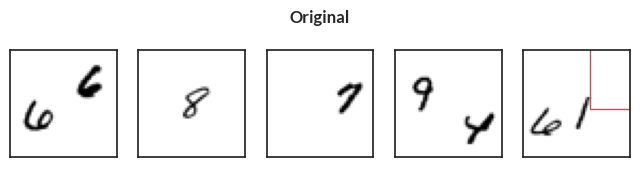

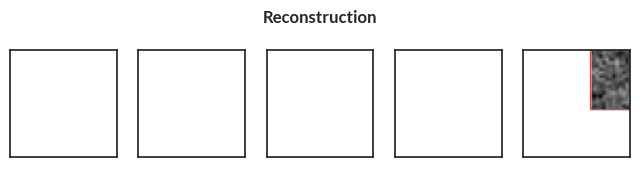

Epoch=1, total_epoch_step_time=2.61, loss=399.84
Epoch=2, total_epoch_step_time=3.92, loss=420.64
Epoch=3, total_epoch_step_time=5.24, loss=438.91
Epoch=4, total_epoch_step_time=6.56, loss=451.74
Epoch=5, total_epoch_step_time=7.88, loss=456.49
Epoch=6, total_epoch_step_time=9.21, loss=458.49
Epoch=7, total_epoch_step_time=10.55, loss=461.23
Epoch=8, total_epoch_step_time=11.88, loss=470.28
Epoch=9, total_epoch_step_time=13.21, loss=487.27
Epoch=10, total_epoch_step_time=14.54, loss=500.34
accuracy=0.23680000007152557, counts=[[11907  6513  1418   110]
 [ 2732  2116  1366 13806]
 [  565   253   185 19029]]


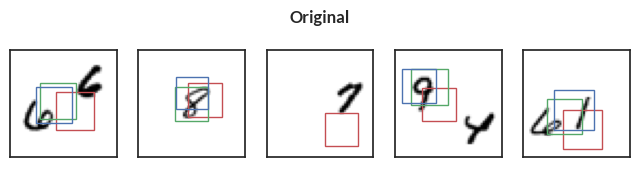

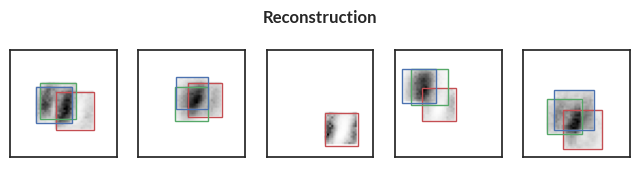

Epoch=11, total_epoch_step_time=15.88, loss=516.81
Epoch=12, total_epoch_step_time=17.25, loss=532.69
Epoch=13, total_epoch_step_time=18.61, loss=546.99
Epoch=14, total_epoch_step_time=19.96, loss=556.42
Epoch=15, total_epoch_step_time=21.33, loss=563.16
Epoch=16, total_epoch_step_time=22.68, loss=569.82
Epoch=17, total_epoch_step_time=24.04, loss=575.58
Epoch=18, total_epoch_step_time=25.41, loss=580.28
Epoch=19, total_epoch_step_time=26.76, loss=584.39
Epoch=20, total_epoch_step_time=28.11, loss=587.42
accuracy=0.22333332896232605, counts=[[13237  6552   159     0]
 [  214   158   126 19522]
 [    5     1     5 20021]]


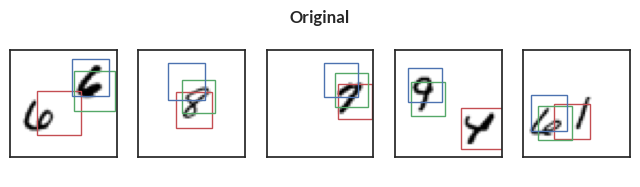

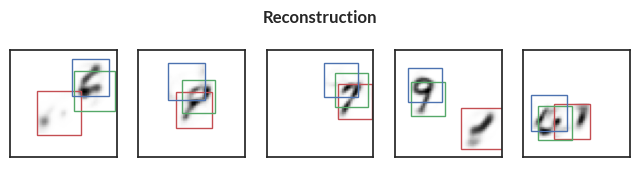

Epoch=21, total_epoch_step_time=29.48, loss=590.25
Epoch=22, total_epoch_step_time=30.84, loss=592.80
Epoch=23, total_epoch_step_time=32.22, loss=595.21
Epoch=24, total_epoch_step_time=33.59, loss=597.29
Epoch=25, total_epoch_step_time=34.96, loss=599.06
Epoch=26, total_epoch_step_time=36.32, loss=600.81
Epoch=27, total_epoch_step_time=37.68, loss=602.39
Epoch=28, total_epoch_step_time=39.05, loss=603.85
Epoch=29, total_epoch_step_time=40.42, loss=605.08
Epoch=30, total_epoch_step_time=41.79, loss=606.23
accuracy=0.2662999927997589, counts=[[15881  4051    16     0]
 [   95    93    44 19788]
 [    2     2     4 20024]]


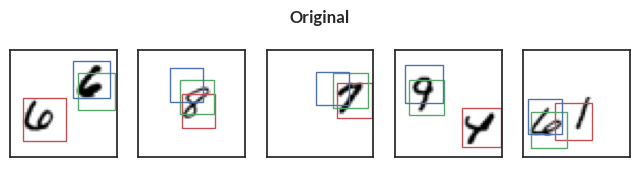

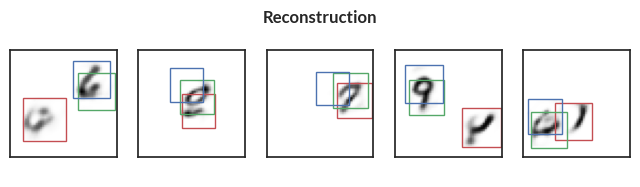

Epoch=31, total_epoch_step_time=43.16, loss=607.33
Epoch=32, total_epoch_step_time=44.52, loss=608.33
Epoch=33, total_epoch_step_time=45.88, loss=609.11
Epoch=34, total_epoch_step_time=47.24, loss=609.92
Epoch=35, total_epoch_step_time=48.61, loss=610.71
Epoch=36, total_epoch_step_time=49.96, loss=611.43
Epoch=37, total_epoch_step_time=51.33, loss=612.13
Epoch=38, total_epoch_step_time=52.69, loss=612.65
Epoch=39, total_epoch_step_time=54.06, loss=613.36
Epoch=40, total_epoch_step_time=55.42, loss=613.80
accuracy=0.2754000127315521, counts=[[16446  3492    10     0]
 [   92    75    62 19791]
 [    3     2     3 20024]]


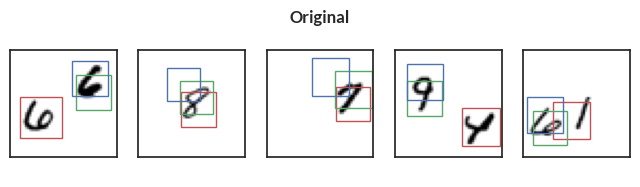

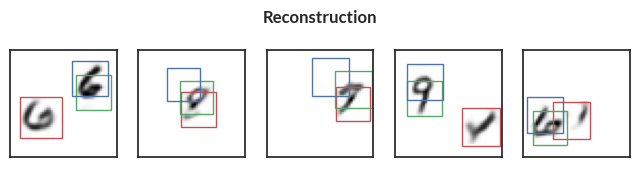

Epoch=41, total_epoch_step_time=56.78, loss=614.30
Epoch=42, total_epoch_step_time=58.14, loss=614.53
Epoch=43, total_epoch_step_time=59.51, loss=614.58
Epoch=44, total_epoch_step_time=60.87, loss=614.79
Epoch=45, total_epoch_step_time=62.24, loss=615.78
Epoch=46, total_epoch_step_time=63.60, loss=616.16
Epoch=47, total_epoch_step_time=64.97, loss=616.45
Epoch=48, total_epoch_step_time=66.33, loss=616.89
Epoch=49, total_epoch_step_time=67.70, loss=616.52
Epoch=50, total_epoch_step_time=69.08, loss=616.65
accuracy=0.31603333353996277, counts=[[18588  1360     0     0]
 [  119   370   531 19000]
 [    2     1     4 20025]]


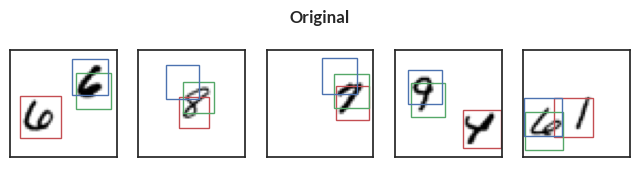

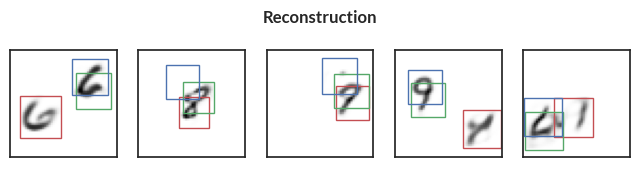

Epoch=51, total_epoch_step_time=70.45, loss=617.35
Epoch=52, total_epoch_step_time=71.82, loss=617.68
Epoch=53, total_epoch_step_time=73.17, loss=617.68
Epoch=54, total_epoch_step_time=74.53, loss=618.13
Epoch=55, total_epoch_step_time=75.88, loss=618.35
Epoch=56, total_epoch_step_time=77.24, loss=618.74
Epoch=57, total_epoch_step_time=78.60, loss=618.87
Epoch=58, total_epoch_step_time=79.96, loss=619.11
Epoch=59, total_epoch_step_time=81.32, loss=619.24
Epoch=60, total_epoch_step_time=82.67, loss=619.22
accuracy=0.32436665892601013, counts=[[19211   737     0     0]
 [  109   249   187 19475]
 [    3     4     2 20023]]


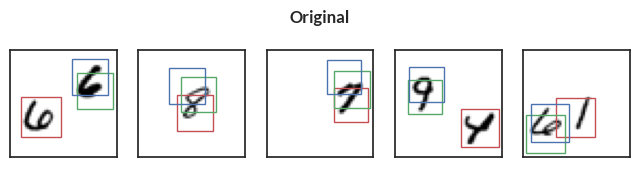

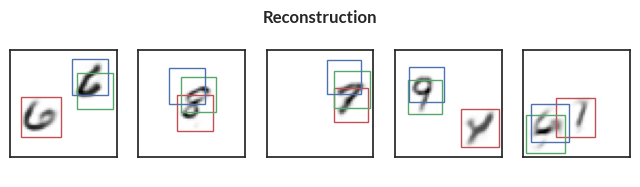

Epoch=61, total_epoch_step_time=84.03, loss=619.47
Epoch=62, total_epoch_step_time=85.38, loss=619.74
Epoch=63, total_epoch_step_time=86.75, loss=619.61
Epoch=64, total_epoch_step_time=88.10, loss=619.98
Epoch=65, total_epoch_step_time=89.46, loss=620.16
Epoch=66, total_epoch_step_time=90.81, loss=620.46
Epoch=67, total_epoch_step_time=92.17, loss=620.67
Epoch=68, total_epoch_step_time=93.52, loss=620.89
Epoch=69, total_epoch_step_time=94.87, loss=621.18
Epoch=70, total_epoch_step_time=96.23, loss=621.24
accuracy=0.32181668281555176, counts=[[19241   706     1     0]
 [   99    68    21 19832]
 [    1     2     0 20029]]


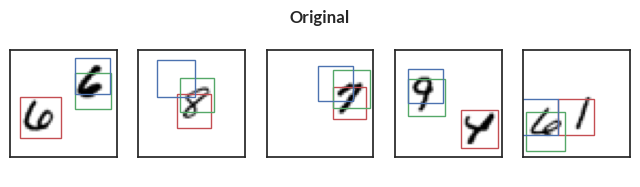

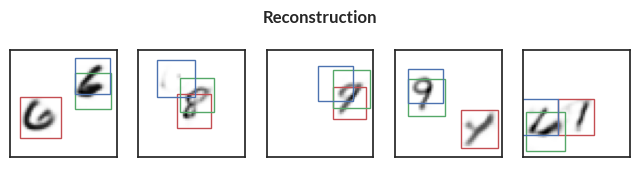

Epoch=71, total_epoch_step_time=97.58, loss=621.50
Epoch=72, total_epoch_step_time=98.94, loss=621.40
Epoch=73, total_epoch_step_time=100.30, loss=621.67
Epoch=74, total_epoch_step_time=101.66, loss=621.56
Epoch=75, total_epoch_step_time=103.02, loss=621.63
Epoch=76, total_epoch_step_time=104.38, loss=621.43
Epoch=77, total_epoch_step_time=105.74, loss=621.52
Epoch=78, total_epoch_step_time=107.09, loss=622.04
Epoch=79, total_epoch_step_time=108.45, loss=622.15
Epoch=80, total_epoch_step_time=109.81, loss=622.34
accuracy=0.33116668462753296, counts=[[19638   310     0     0]
 [  144   231   115 19530]
 [    1     4     1 20026]]


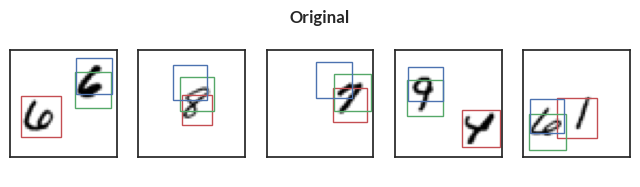

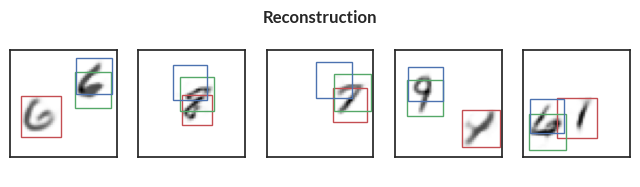

Epoch=81, total_epoch_step_time=111.17, loss=622.54
Epoch=82, total_epoch_step_time=112.53, loss=622.47
Epoch=83, total_epoch_step_time=113.89, loss=622.52
Epoch=84, total_epoch_step_time=115.24, loss=622.70
Epoch=85, total_epoch_step_time=116.60, loss=623.12
Epoch=86, total_epoch_step_time=117.96, loss=623.16
Epoch=87, total_epoch_step_time=119.32, loss=623.29
Epoch=88, total_epoch_step_time=120.68, loss=623.22
Epoch=89, total_epoch_step_time=122.04, loss=623.43
Epoch=90, total_epoch_step_time=123.39, loss=623.57
accuracy=0.3316666781902313, counts=[[19737   211     0     0]
 [   97   158    66 19699]
 [    3     5     5 20019]]


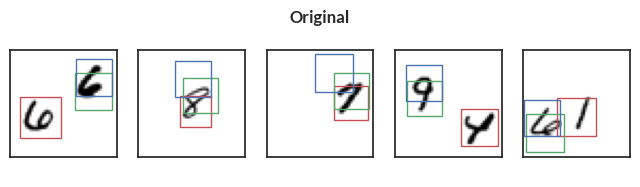

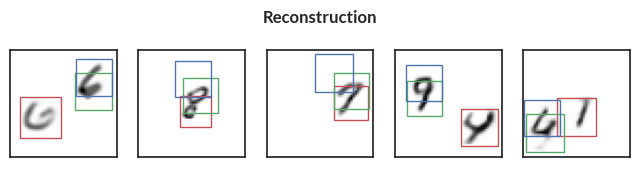

Epoch=91, total_epoch_step_time=124.75, loss=623.72
Epoch=92, total_epoch_step_time=126.12, loss=623.53
Epoch=93, total_epoch_step_time=127.49, loss=624.06
Epoch=94, total_epoch_step_time=128.84, loss=624.18
Epoch=95, total_epoch_step_time=130.21, loss=624.29
Epoch=96, total_epoch_step_time=131.56, loss=624.38
Epoch=97, total_epoch_step_time=132.92, loss=624.44
Epoch=98, total_epoch_step_time=134.28, loss=624.61
Epoch=99, total_epoch_step_time=135.63, loss=624.67
Epoch=100, total_epoch_step_time=136.99, loss=624.86
accuracy=0.33070001006126404, counts=[[19828   120     0     0]
 [   66    11     4 19939]
 [    3     3     3 20023]]


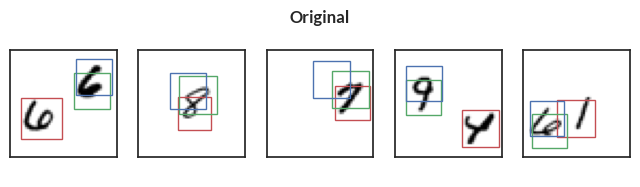

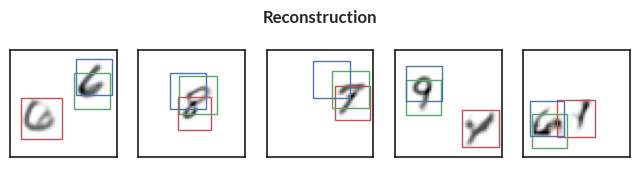

Epoch=101, total_epoch_step_time=138.35, loss=625.00
Epoch=102, total_epoch_step_time=139.71, loss=625.07
Epoch=103, total_epoch_step_time=141.07, loss=625.12
Epoch=104, total_epoch_step_time=142.43, loss=625.19
Epoch=105, total_epoch_step_time=143.79, loss=625.29
Epoch=106, total_epoch_step_time=145.15, loss=625.33
Epoch=107, total_epoch_step_time=146.51, loss=625.47
Epoch=108, total_epoch_step_time=147.87, loss=625.56
Epoch=109, total_epoch_step_time=149.23, loss=625.67
Epoch=110, total_epoch_step_time=150.58, loss=625.56
accuracy=0.33204999566078186, counts=[[19894    54     0     0]
 [   86    25     5 19904]
 [    3     1     4 20024]]


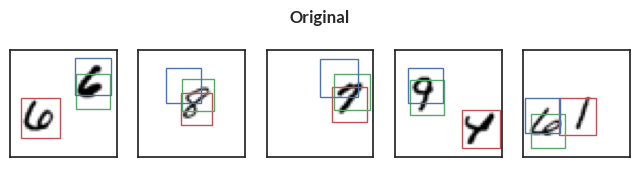

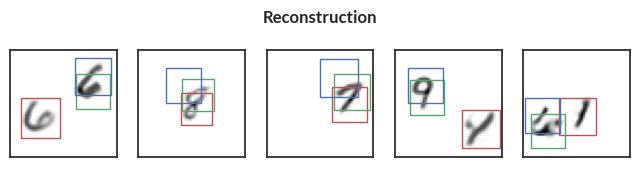

Epoch=111, total_epoch_step_time=151.93, loss=625.82
Epoch=112, total_epoch_step_time=153.32, loss=625.85
Epoch=113, total_epoch_step_time=154.68, loss=625.92
Epoch=114, total_epoch_step_time=156.04, loss=625.96
Epoch=115, total_epoch_step_time=157.39, loss=626.04
Epoch=116, total_epoch_step_time=158.76, loss=626.08
Epoch=117, total_epoch_step_time=160.11, loss=626.18
Epoch=118, total_epoch_step_time=161.47, loss=626.30
Epoch=119, total_epoch_step_time=162.82, loss=626.29
Epoch=120, total_epoch_step_time=164.17, loss=626.47
accuracy=0.3319333493709564, counts=[[19891    57     0     0]
 [   61    23     8 19928]
 [    3     2     2 20025]]


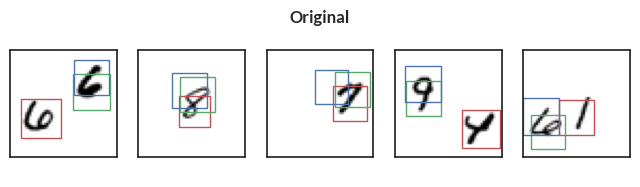

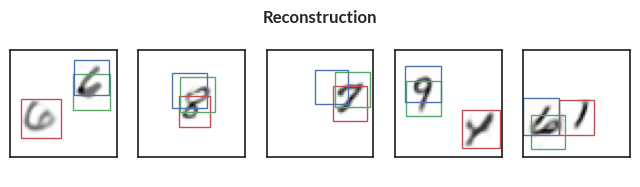

Epoch=121, total_epoch_step_time=165.52, loss=626.49
Epoch=122, total_epoch_step_time=166.88, loss=626.56
Epoch=123, total_epoch_step_time=168.22, loss=626.58
Epoch=124, total_epoch_step_time=169.58, loss=626.64
Epoch=125, total_epoch_step_time=170.93, loss=626.75
Epoch=126, total_epoch_step_time=172.29, loss=626.78
Epoch=127, total_epoch_step_time=173.64, loss=626.78
Epoch=128, total_epoch_step_time=175.00, loss=626.74
Epoch=129, total_epoch_step_time=176.35, loss=626.79
Epoch=130, total_epoch_step_time=177.70, loss=626.92
accuracy=0.3326833248138428, counts=[[19920    28     0     0]
 [   75    38    12 19895]
 [    6     2     3 20021]]


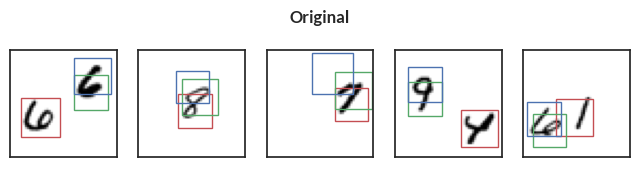

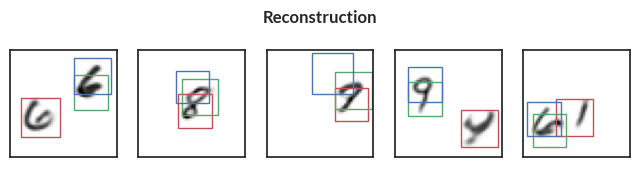

Epoch=131, total_epoch_step_time=179.06, loss=627.03
Epoch=132, total_epoch_step_time=180.42, loss=627.05
Epoch=133, total_epoch_step_time=181.77, loss=627.07
Epoch=134, total_epoch_step_time=183.14, loss=627.08
Epoch=135, total_epoch_step_time=184.50, loss=627.17
Epoch=136, total_epoch_step_time=185.88, loss=627.23
Epoch=137, total_epoch_step_time=187.23, loss=627.23
Epoch=138, total_epoch_step_time=188.60, loss=627.28
Epoch=139, total_epoch_step_time=189.95, loss=627.52
Epoch=140, total_epoch_step_time=191.31, loss=627.51
accuracy=0.33285000920295715, counts=[[19932    16     0     0]
 [   79    37     9 19895]
 [    4     1     2 20025]]


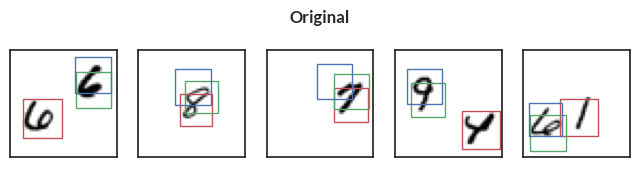

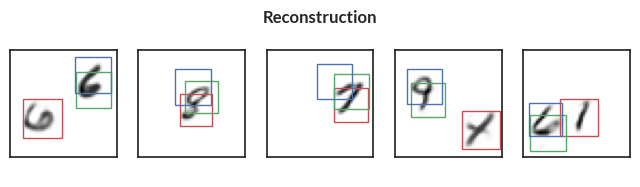

Epoch=141, total_epoch_step_time=192.66, loss=627.51
Epoch=142, total_epoch_step_time=194.04, loss=627.54
Epoch=143, total_epoch_step_time=195.39, loss=627.65
Epoch=144, total_epoch_step_time=196.75, loss=627.77
Epoch=145, total_epoch_step_time=198.10, loss=627.75
Epoch=146, total_epoch_step_time=199.46, loss=627.76
Epoch=147, total_epoch_step_time=200.81, loss=627.89
Epoch=148, total_epoch_step_time=202.17, loss=627.89
Epoch=149, total_epoch_step_time=203.52, loss=627.83
Epoch=150, total_epoch_step_time=204.88, loss=627.92
accuracy=0.33266666531562805, counts=[[19935    13     0     0]
 [   68    25     3 19924]
 [    4     2     0 20026]]


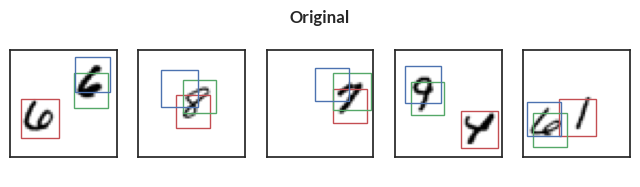

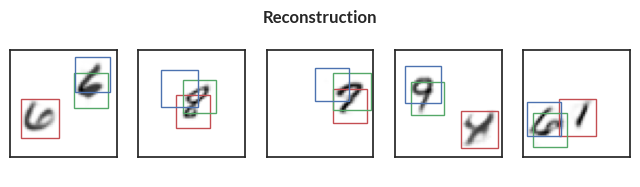

Epoch=151, total_epoch_step_time=206.24, loss=628.14
Epoch=152, total_epoch_step_time=207.60, loss=628.14
Epoch=153, total_epoch_step_time=208.96, loss=628.13
Epoch=154, total_epoch_step_time=210.32, loss=628.20
Epoch=155, total_epoch_step_time=211.67, loss=628.24
Epoch=156, total_epoch_step_time=213.05, loss=628.15
Epoch=157, total_epoch_step_time=214.41, loss=628.15
Epoch=158, total_epoch_step_time=215.78, loss=628.30
Epoch=159, total_epoch_step_time=217.14, loss=628.37
Epoch=160, total_epoch_step_time=218.52, loss=628.33
accuracy=0.3325333297252655, counts=[[19927    21     0     0]
 [   69    22     5 19924]
 [    2     2     3 20025]]


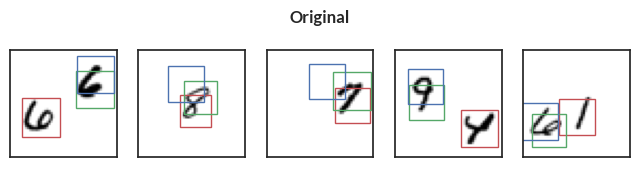

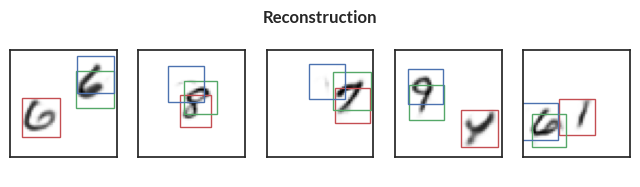

Epoch=161, total_epoch_step_time=219.87, loss=628.49
Epoch=162, total_epoch_step_time=221.25, loss=628.49
Epoch=163, total_epoch_step_time=222.61, loss=628.51
Epoch=164, total_epoch_step_time=223.98, loss=628.49
Epoch=165, total_epoch_step_time=225.34, loss=628.69
Epoch=166, total_epoch_step_time=226.72, loss=628.69
Epoch=167, total_epoch_step_time=228.07, loss=628.62
Epoch=168, total_epoch_step_time=229.45, loss=628.74
Epoch=169, total_epoch_step_time=230.81, loss=628.79
Epoch=170, total_epoch_step_time=232.18, loss=628.84
accuracy=0.3323666751384735, counts=[[19921    27     0     0]
 [   70    17     0 19933]
 [    1     1     4 20026]]


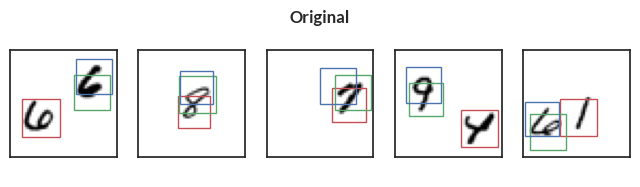

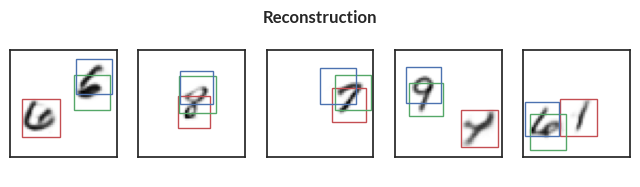

Epoch=171, total_epoch_step_time=233.54, loss=628.89
Epoch=172, total_epoch_step_time=234.92, loss=628.86
Epoch=173, total_epoch_step_time=236.27, loss=628.91
Epoch=174, total_epoch_step_time=237.65, loss=628.93
Epoch=175, total_epoch_step_time=239.00, loss=628.91
Epoch=176, total_epoch_step_time=240.38, loss=628.94
Epoch=177, total_epoch_step_time=241.74, loss=628.91
Epoch=178, total_epoch_step_time=243.11, loss=629.05
Epoch=179, total_epoch_step_time=244.47, loss=629.11
Epoch=180, total_epoch_step_time=245.85, loss=629.22
accuracy=0.33231666684150696, counts=[[19930    18     0     0]
 [   73     9     4 19934]
 [    0     1     0 20031]]


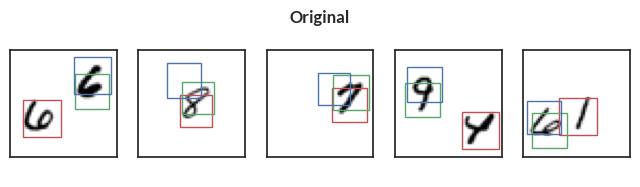

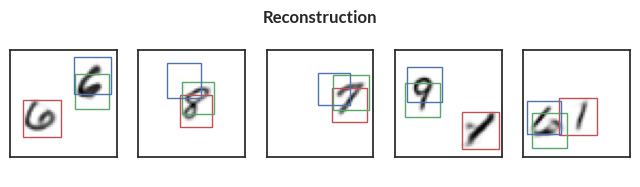

Epoch=181, total_epoch_step_time=247.20, loss=629.20
Epoch=182, total_epoch_step_time=248.58, loss=629.24
Epoch=183, total_epoch_step_time=249.94, loss=629.21
Epoch=184, total_epoch_step_time=251.31, loss=629.23
Epoch=185, total_epoch_step_time=252.67, loss=629.31
Epoch=186, total_epoch_step_time=254.05, loss=629.36
Epoch=187, total_epoch_step_time=255.40, loss=629.42
Epoch=188, total_epoch_step_time=256.78, loss=629.40
Epoch=189, total_epoch_step_time=258.14, loss=629.36
Epoch=190, total_epoch_step_time=259.51, loss=629.54
accuracy=0.3326333463191986, counts=[[19938    10     0     0]
 [   82    18     6 19914]
 [    1     3     2 20026]]


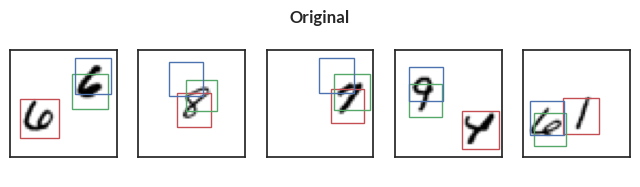

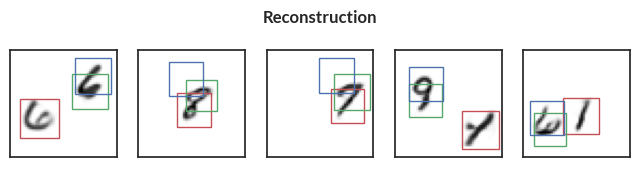

Epoch=191, total_epoch_step_time=260.87, loss=629.43
Epoch=192, total_epoch_step_time=262.25, loss=629.42
Epoch=193, total_epoch_step_time=263.60, loss=629.42
Epoch=194, total_epoch_step_time=264.98, loss=629.50
Epoch=195, total_epoch_step_time=266.33, loss=629.54
Epoch=196, total_epoch_step_time=267.71, loss=629.57
Epoch=197, total_epoch_step_time=269.06, loss=629.57
Epoch=198, total_epoch_step_time=270.44, loss=629.69
Epoch=199, total_epoch_step_time=271.79, loss=629.70
Epoch=200, total_epoch_step_time=273.17, loss=629.76
accuracy=0.3328833281993866, counts=[[19937    11     0     0]
 [   84    31     6 19899]
 [    2     1     5 20024]]


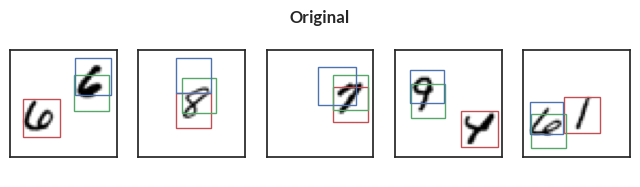

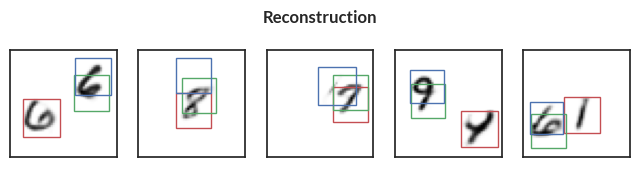

In [16]:
batch_size = 64
learning_rate = 1.0e-4
num_epochs = 200


def svi_update(model, guide, optimiser):
    def batch_updater(key, params, opt_state, data_batch):
        def grads(key, params, data):
            (decoder, rnn, encoder, predict) = params
            data = genjax.choice_map({"obs": data})
            objective = grasp.iwae_elbo(model, guide, data, 1)
            loss, (
                (decoder_grads,),
                (_, rnn_grads, encoder_grads, predict_grads),
            ) = objective.value_and_grad_estimate(
                key, ((decoder,), (data, rnn, encoder, predict))
            )
            return loss, (decoder_grads, rnn_grads, encoder_grads, predict_grads)

        sub_keys = jax.random.split(key, len(data_batch))
        loss, (decoder_grads, rnn_grads, encoder_grads, predict_grads) = jax.vmap(
            grads, in_axes=(0, None, 0)
        )(sub_keys, params, data_batch)

        grads = jtu.tree_map(
            lambda v: -1.0 * jnp.mean(v, axis=0),
            (decoder_grads, rnn_grads, encoder_grads, predict_grads),
        )
        updates, opt_state = optimiser.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss = jnp.mean(loss)
        return params, opt_state, loss

    return batch_updater


adam = optax.adam(learning_rate)
svi_updater = svi_update(model, guide, adam)
train_init, train_fetch = data_loader(jnp.array(mnist), batch_size)
key, sub_key = jax.random.split(key)
num_batch, train_idx = train_init(sub_key)


@jax.jit
def epoch_train(opt_state, params, key, train_idx):
    def body_fn(carry, xs):
        idx, params, opt_state, loss = carry
        updater_key = jax.random.fold_in(key, idx)
        batch = train_fetch(idx, train_idx)
        params, opt_state, loss = svi_updater(updater_key, params, opt_state, batch)
        idx += 1
        return (idx, params, opt_state, loss), loss

    idx = 0
    (_, params, opt_state, _), losses = jax.lax.scan(
        body_fn, (idx, params, opt_state, 0.0), None, length=num_batch
    )
    return params, opt_state, losses


# Train.
params = (decoder, rnn, encoder, predict)
opt_state = adam.init(params)
losses = []
accuracy = []
acc_time = 0.0

# Warm up.
_ = epoch_train(opt_state, params, key, train_idx)

t0 = time.perf_counter()
acc_time = 0.0
for i in range(0, num_epochs + 1):
    key, sub_key = jax.random.split(key)
    num_batch, train_idx = train_init(sub_key)
    key, sub_key = jax.random.split(key)
    start = time.perf_counter() - t0
    params, opt_state, loss = epoch_train(opt_state, params, sub_key, train_idx)
    stop = time.perf_counter() - t0
    acc_time += stop - start
    print(f"Epoch={i}, total_epoch_step_time={acc_time:.2f}, loss={jnp.mean(loss):.2f}")
    losses.append(jnp.mean(loss))
    if i % 10 == 0:
        acc, counts, error_ix = evaluate_accuracy(sub_key, params[1:])
        accuracy.append(acc)
        print("accuracy={}, counts={}".format(acc, counts))
    if i % 10 == 0:
        visualize(sub_key, params, visualize_examples)

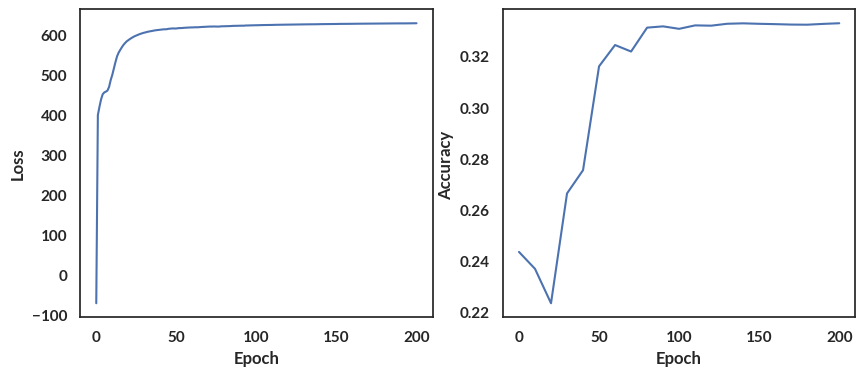

In [17]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, num_epochs, len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(np.linspace(0, num_epochs, len(accuracy)), accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy");